# Markowitz Portfolio Theory: Optimization & Backtesting

This project implements a complete portfolio optimization workflow based on Modern Portfolio Theory (Markowitz, 1952).

- Convex optimization for risk minimization
- Sharpe ratio maximization for the tangency portfolio
- Risk–return trade-off using the Efficient Frontier
- Capital Market Line (CML) construction


### Some tested constraints
- Full-investment constraint 
- Long-only bounds 
- Scenario with capped weights  
- Impact of constraints on the Efficient Frontier


### Backtesting Framework: Cumulative return comparison across
- Global Minimum Variance (GMV) Portfolio
- Tangency Portfolio
- Equal Weight Portfolio

In [62]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore", message=".*date_parser.*", category=FutureWarning)
warnings.filterwarnings("ignore")

## Fetching data from Yahoo Finance

In [63]:
tickers = ["TSLA", "WMT", "BAC", "GS", "LLY", "MRK", "GOOG", "META", "AAPL", "XOM"]

start_date = "2020-07-01"
end_date = "2025-06-30"
test_start_date = "2025-07-01"
test_end_date = "2025-10-30"

df = yf.download(
    tickers, start=start_date, end=end_date,
    auto_adjust=True, progress=False, interval="1d"
)["Close"]

# For the test period
df_test = yf.download(
    tickers, start=test_start_date, end=test_end_date,
    auto_adjust=True, progress=False, interval="1d"
)["Close"]

df_all = pd.concat([df, df_test])
returns_all = df_all.pct_change().dropna()

print(df.shape)
df.head()

(1254, 10)


Ticker,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
Date,,,,,,,,,,
2020-07-01,88.299103,20.450165,71.413300,174.300842,153.428146,236.094543,63.182007,74.641998,37.063190,34.208160
2020-07-02,88.299103,20.476538,72.737244,174.150848,153.963715,231.989853,63.715820,80.577332,36.914543,34.497734
2020-07-06,90.661125,20.801840,74.276711,182.937820,156.801163,238.807816,64.362831,91.438667,36.815456,34.740337
2020-07-07,90.379837,20.230360,73.754288,175.880005,156.669617,239.384277,63.667301,92.657333,39.311321,33.840336
2020-07-08,92.484779,20.309490,74.291603,178.429657,158.905701,242.087616,63.020256,91.058670,38.534065,33.762081


In [64]:
rets = df.pct_change().dropna()
print(rets.shape)
rets.head()

(1253, 10)


Ticker,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
Date,,,,,,,,,,
2020-07-02,0.000000,0.001290,0.018539,-0.000861,0.003491,-0.017386,0.008449,0.079517,-0.004011,0.008465
2020-07-06,0.026750,0.015887,0.021165,0.050456,0.018429,0.029389,0.010155,0.134794,-0.002684,0.007032
2020-07-07,-0.003103,-0.027473,-0.007033,-0.038580,-0.000839,0.002414,-0.010806,0.013328,0.067794,-0.025907
2020-07-08,0.023290,0.003911,0.007285,0.014497,0.014273,0.011293,-0.010163,-0.017254,-0.019772,-0.002312
2020-07-09,0.004300,-0.014286,0.010020,-0.026798,-0.015846,0.003777,-0.015785,0.020792,0.026599,-0.041261


### Stock Prices

The stocks exhibit very different behaviors and operate on different price scales.

The strong heterogeneity in price dynamics suggests meaningful opportunities for cross-sector diversification.


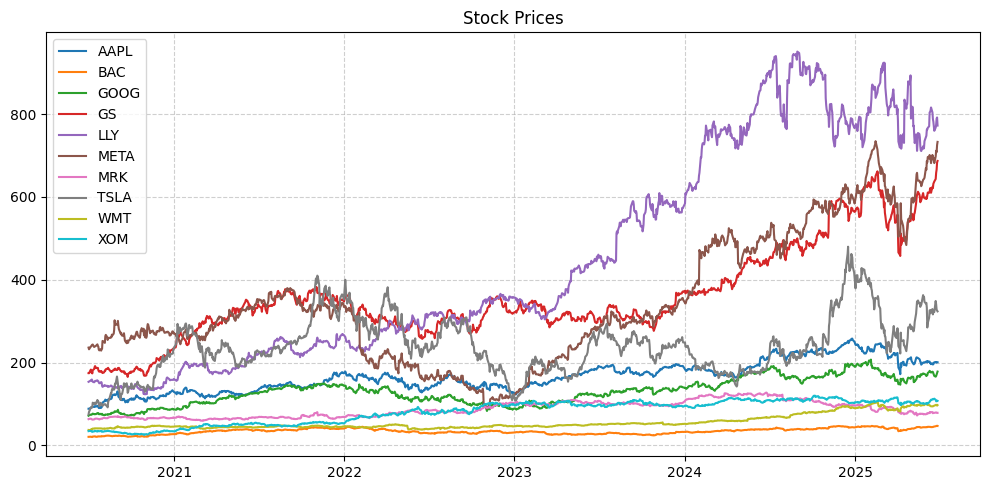

In [65]:
plt.figure(figsize=(10, 5))
for c in df.columns:
    plt.plot(df.index, df[c], label=c, linewidth=1.5)
plt.title("Stock Prices")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Daily Returns

From daily returns, we can observe:
- high-frequency noise centered near 0 with occasional extreme spikes
- volatility clustering is visible

Most assets approximate a bell-shape but with fat tails:
- some slight skewness in a few assets 

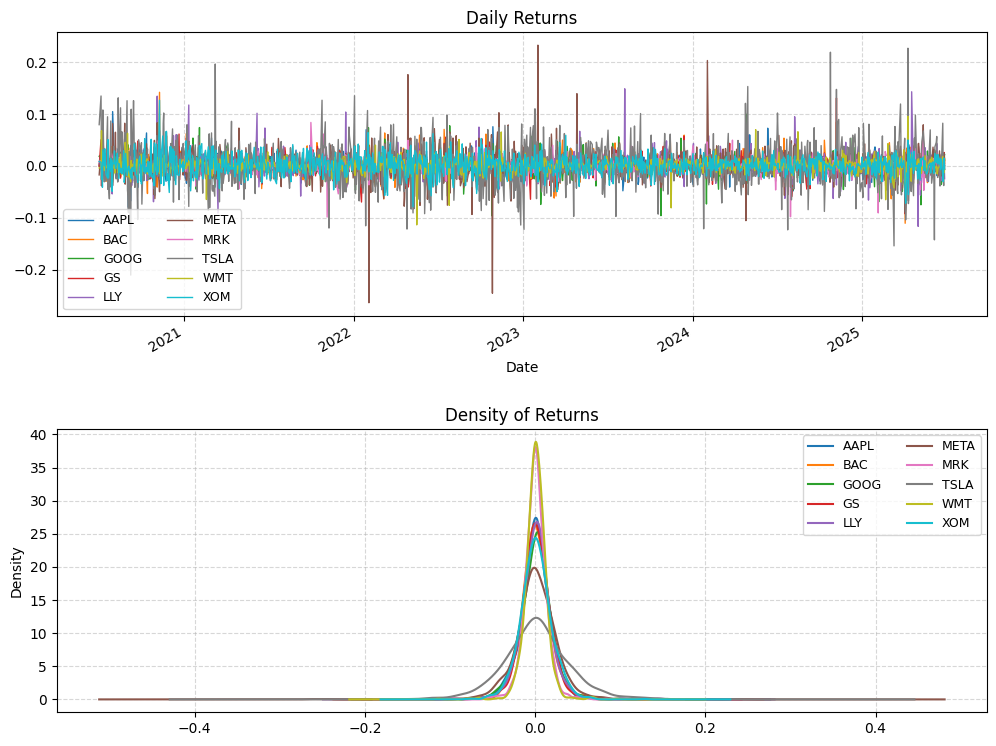

In [66]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), 
                         gridspec_kw={'hspace': 0.4})

# Daily Returns  
rets.plot(ax=axes[0], linewidth=1)
axes[0].set_title("Daily Returns")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(ncol=2, fontsize=9)

# Density of Returns 
rets.plot(kind='density', ax=axes[1])
axes[1].set_title("Density of Returns")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

### Cumulative Returns (per asset)

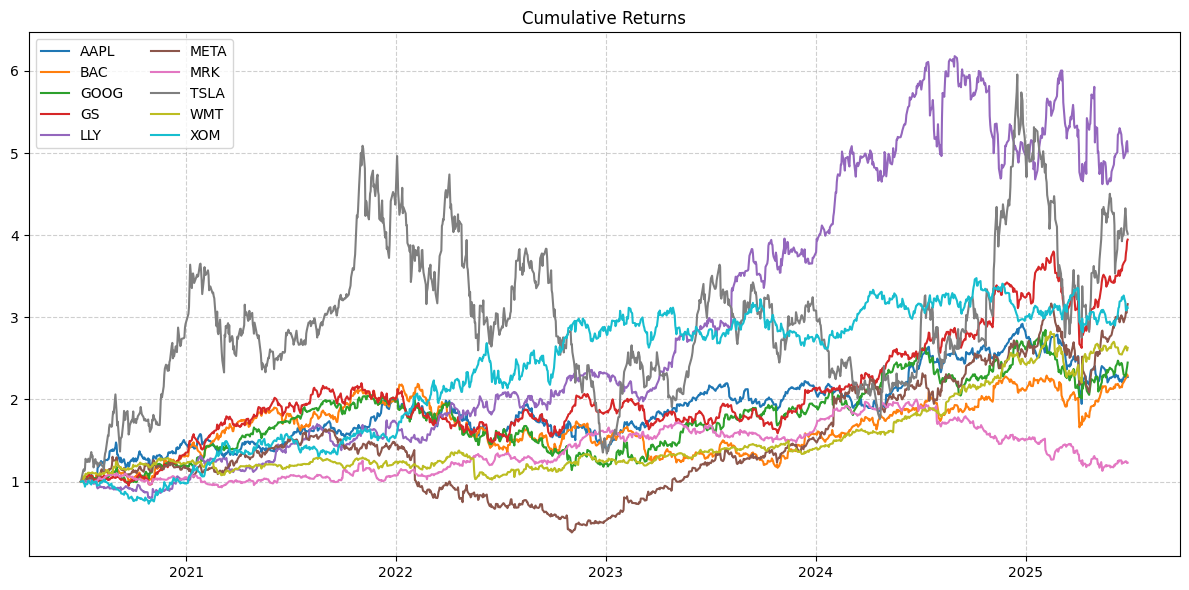

In [67]:
# Cumulative returns
cumulative_returns = (1 + rets).cumprod()
# Normalize to get 1.0 at starting point
cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]

plt.figure(figsize=(12, 6))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker, linewidth=1.5)
plt.title("Cumulative Returns")
plt.legend(loc='upper left',ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Clustered Correlation Matrix of Returns

From that, we notice:
- Tech cluster (GOOG, META, AAPL) shows moderate positive correlations
- Financials (BAC, GS) are fairly correlated
- Some cross-sector low correlations (e.g., healthcare vs others), offering diversification benefits



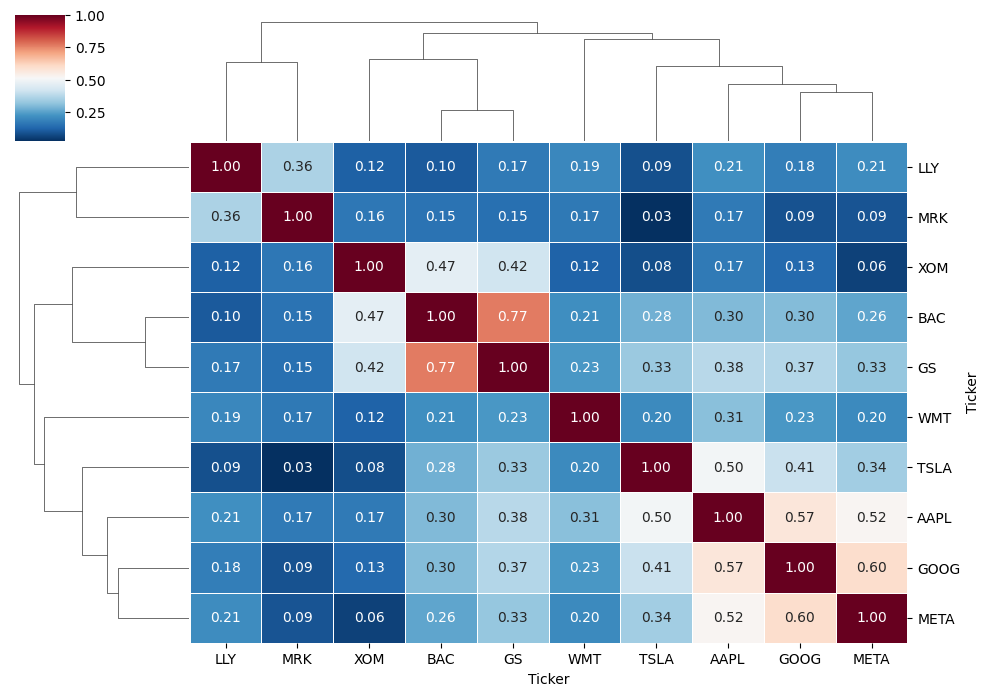

In [ ]:
sns.clustermap(
    rets.corr(), annot=True, fmt=".2f", cmap='RdBu_r',
    linewidths=0.5, figsize=(10, 7),
)
plt.show()

### Defining parameters

In [69]:
TRADING_DAYS = 252

# annualized expected returns
mu = rets.mean() * TRADING_DAYS

# annualized covariance
Sigma = rets.cov() * TRADING_DAYS   

tickers = rets.columns.tolist()

________
# I. Markowitz Mean-Variance Optimization


## 1. Minimum variance (Efficient Frontier)

Minimize variance for a required expected portfolio return $\mathbb{E}[R_p]$:

$$
\begin{aligned}
\min_{w}\quad & w^T \Sigma\, w 

\quad\quad\quad \text{s.t.} \ &
\begin{cases}
w^T \mu = E[R_p]   \\[6pt]
\mathbf{1}^T w = 1  \\[6pt]
0 \le w_i \le 1
\end{cases}
\end{aligned}$$




## 2. Global Minimum Variance portfolio (GMV)

Minimize variance 

$$
\begin{aligned}
\min_{w}\quad & w^T \Sigma\, w 

\quad\quad\quad \text{s.t.} \ &
\begin{cases}
\mathbf{1}^T w = 1  \\[6pt]
0 \le w_i \le 1  
\end{cases}
\end{aligned}$$


## 3. Tangency portfolio (Maximum Sharpe ratio)

Maximize the Sharpe ratio:

$$
\begin{aligned}
\max_{w}\quad & \dfrac{w^T \mu - r_f}{\sqrt{\,w^T \Sigma\, w\,}} 

\quad\quad\quad \text{s.t.} \ &
\begin{cases}
\mathbf{1}^T w = 1 \\[6pt]
0 \le w_i \le 1  
\end{cases}
\end{aligned}$$


In [70]:
def portfolio_performance(W, mu, cov, rf=0):
    ret = W @ mu
    vol = np.sqrt(W @ cov @ W)
    sharpe = (ret - rf) / vol
    return ret, vol, sharpe

def portfolio_volatility(W, mu, cov):
    return np.sqrt(W @ cov @ W)

def neg_sharpe_ratio(W, mu, cov, rf=0.0):
    ret, vol, _ = portfolio_performance(W, mu, cov, rf)
    return -(ret - rf) / vol

def optimize_portfolio(objective, mu, cov, opt_param, extra_args=()):
    """ Generic optimizer """
    w0 = opt_param['w0']
    bounds = opt_param['bounds']
    constraints = opt_param['constraints']
    
    result = minimize(objective, w0, args=(mu, cov, *extra_args),
                      method='SLSQP', bounds=bounds,
                      constraints=constraints,
                      options={'maxiter':500, 'ftol':1e-9})
    return result.x if result.success else None

In [71]:
def gmv_portfolio(mu, Sigma, opt_param):
    """ GMV Portfolio """
    w = optimize_portfolio(portfolio_volatility, mu, Sigma, opt_param)
    return portfolio_performance(w, mu, Sigma) + (w,)

def tangency_portfolio(mu, Sigma, opt_param, rf=0.0):
    """ Tangency Portfolio """
    w = optimize_portfolio(neg_sharpe_ratio, mu, Sigma, opt_param, extra_args=(rf,))
    return portfolio_performance(w, mu, Sigma, rf) + (w,)

def efficient_frontier(mu, Sigma, opt_param, n_points=100):
    """ Efficient Frontier """
    target_returns = np.linspace(mu.min(), mu.max(), n_points)
    target_vols = []
    for target in target_returns:
        # Add target return as equality constraint
        cons = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w, target=target: w @ mu - target}
        )
        temp_param = opt_param.copy()
        temp_param['constraints'] = cons
        w = optimize_portfolio(portfolio_volatility, mu, Sigma, temp_param)
        
        if w is None:
            target_vols.append(np.nan)
        else:
            target_vols.append(np.sqrt(w @ Sigma @ w))

    target_returns = np.array(target_returns)
    target_vols    = np.array(target_vols)

    mask = ~np.isnan(target_vols)
    return target_returns[mask], target_vols[mask]

In [94]:
def portfolio_w_df(ret_gmv, vol_gmv, sharpe_gmv, w_gmv,
                   ret_tan, vol_tan, sharpe_tan, w_tan):
    portfolios = {
        'GMV': {'Return': ret_gmv, 'Volatility': vol_gmv, 'Sharpe': sharpe_gmv, 'Weights': w_gmv},
        'Tangency': {'Return': ret_tan, 'Volatility': vol_tan, 'Sharpe': sharpe_tan, 'Weights': w_tan}
    }

    # summary
    summary_df = pd.DataFrame({
        'Expected Return': [portfolios[p]['Return'] for p in portfolios],
        'Volatility': [portfolios[p]['Volatility'] for p in portfolios],
        'Sharpe Ratio': [portfolios[p]['Sharpe'] for p in portfolios]
    }, index=list(portfolios.keys()))

    # Weights DataFrame
    weights_df = pd.DataFrame({p: portfolios[p]['Weights'] for p in portfolios}, index=mu.index)

    full_summary_df = pd.concat([summary_df, weights_df.T], axis=1)
    full_summary_df
    return full_summary_df, weights_df

### Optimization with no-shorting

In [72]:
# Constraints and bounds
rf = 0.2
n = len(rets.columns)
min_w, max_w = 0.0, 1.0
opt_param = {
    'w0': np.ones(n) / n,
    'constraints': ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},),
    'bounds': tuple((min_w, max_w) for _ in range(n))
}

# GMV
ret_gmv, vol_gmv, sharpe_gmv, w_gmv = gmv_portfolio(mu, Sigma, opt_param)

# Tangency
ret_tan, vol_tan, sharpe_tan, w_tan = tangency_portfolio(mu, Sigma, opt_param, rf=rf)

# Efficient Frontier
target_returns, target_vols = efficient_frontier(mu, Sigma, opt_param)

In [96]:
full_summary_df, weights_df = portfolio_w_df(ret_gmv, vol_gmv, sharpe_gmv, w_gmv,
                                             ret_tan, vol_tan, sharpe_tan, w_tan)
full_summary_df

,Expected Return,Volatility,Sharpe Ratio,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
GMV,0.191272,0.146014,1.309957,0.017208,4.320251e-02,9.165152e-02,0.037855,0.053328,0.000000e+00,0.303017,3.973323e-18,3.298506e-01,0.123888
Tangency,0.375297,0.240962,0.727490,0.000000,2.735183e-16,9.723125e-18,0.201393,0.506654,3.493511e-17,0.000000,1.864006e-01,3.254279e-17,0.105553


- GMV weights concentrate on low-volatility assets (defensive names) as it reduces volatility at the expense of expected return
- Tangency portfolio is more concentrated in assets with higher risk-adjusted returns (higher Sharpe) as it maximizes risk-adjusted return

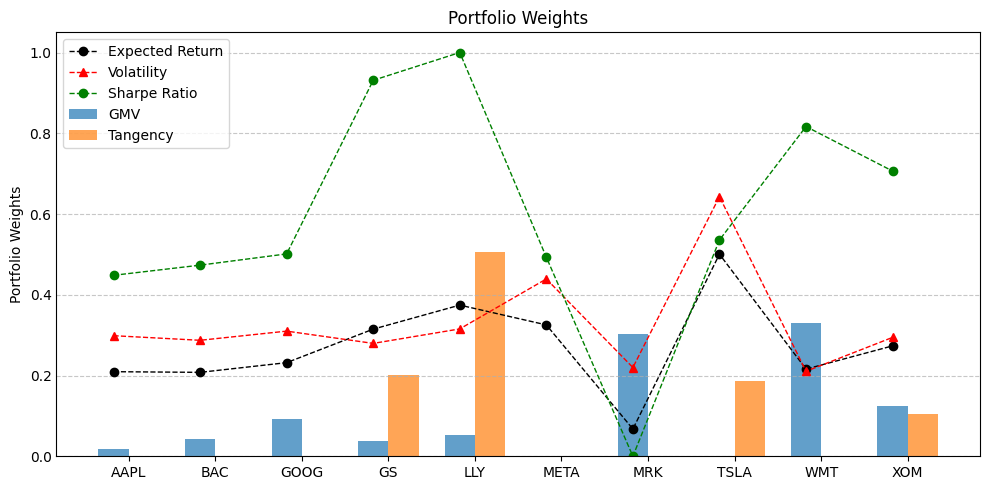

In [93]:
n_assets = weights_df.shape[0]
n_portfolios = weights_df.shape[1]

asset_vols = np.sqrt(np.diag(Sigma))
asset_sharpe = mu / asset_vols  
# Normalize Sharpe
sharpe_norm = (asset_sharpe - asset_sharpe.min()) / (asset_sharpe.max() - asset_sharpe.min())

# Bar positions
x = np.arange(n_assets)
width = 0.35 

# Plot portfolio weights
fig, ax = plt.subplots(figsize=(10, 5))
for i, p in enumerate(weights_df.columns):
    ax.bar(x + i*width, weights_df[p], width=width, label=p, alpha=0.7)
ax.set_xticks(x + width*(n_portfolios-1)/2)
ax.set_xticklabels(weights_df.index)
ax.set_ylabel("Portfolio Weights")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Overlay mean and volatility 
ax.plot(x, mu, 'ko--', linewidth=1, markersize=6, label='Expected Return')
ax.plot(x, asset_vols, 'r^--', linewidth=1, markersize=6, label='Volatility')
ax.plot(x, sharpe_norm, 'go--', linewidth=1, markersize=6, label='Sharpe Ratio')

# Hide ticks and labels for overlay
ax.tick_params(axis='y', which='both', length=0) 
ax.yaxis.label.set_visible(True)  
ax.legend(loc='upper left')
plt.title("Portfolio Weights")
plt.tight_layout()
plt.show()

### Portfolio with capped weights (20%)

In [75]:
# Constraints and bounds
rf = 0.2
n = len(rets.columns)
min_w, max_w = 0.0, 0.2
opt_param = {
    'w0': np.ones(n) / n,
    'constraints': ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},),
    'bounds': tuple((min_w, max_w) for _ in range(n))
}

# GMV
ret_gmv_cap, vol_gmv_cap, sharpe_gmv_cap, w_gmv_cap = gmv_portfolio(mu, Sigma, opt_param)

# Tangency
ret_tan_cap, vol_tan_cap, sharpe_tan_cap, w_tan_cap = tangency_portfolio(mu, Sigma, opt_param, rf=rf)

# Efficient Frontier
target_returns_cap, target_vols_cap = efficient_frontier(mu, Sigma, opt_param)

In [98]:
full_summary_df, weights_df = portfolio_w_df(ret_gmv_cap, vol_gmv_cap, sharpe_gmv_cap, w_gmv_cap,
                                             ret_tan_cap, vol_tan_cap, sharpe_tan_cap, w_tan_cap)
full_summary_df

,Expected Return,Volatility,Sharpe Ratio,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
GMV,0.221280,0.152484,1.451171,6.586817e-02,0.079314,0.113817,0.049446,0.125012,0.000000,0.2,4.275822e-18,0.200000,0.166543
Tangency,0.347487,0.227845,0.647314,6.276110e-19,0.000000,0.000000,0.200000,0.200000,0.106329,0.0,2.000000e-01,0.093671,0.200000


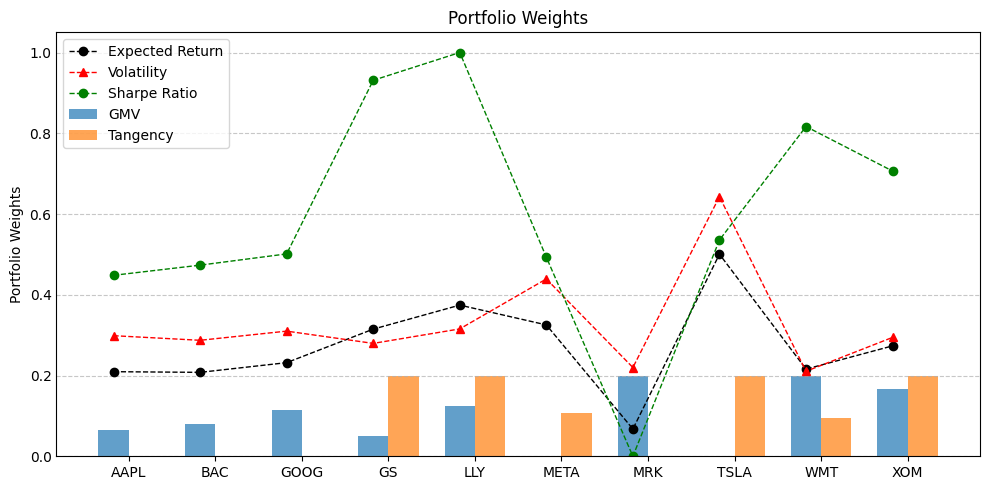

In [99]:
# Bar positions
x = np.arange(n_assets)
width = 0.35 

# Plot portfolio weights
fig, ax = plt.subplots(figsize=(10, 5))
for i, p in enumerate(weights_df.columns):
    ax.bar(x + i*width, weights_df[p], width=width, label=p, alpha=0.7)
ax.set_xticks(x + width*(n_portfolios-1)/2)
ax.set_xticklabels(weights_df.index)
ax.set_ylabel("Portfolio Weights")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Overlay mean and volatility 
ax.plot(x, mu, 'ko--', linewidth=1, markersize=6, label='Expected Return')
ax.plot(x, asset_vols, 'r^--', linewidth=1, markersize=6, label='Volatility')
ax.plot(x, sharpe_norm, 'go--', linewidth=1, markersize=6, label='Sharpe Ratio')

# Hide ticks and labels for overlay
ax.tick_params(axis='y', which='both', length=0) 
ax.yaxis.label.set_visible(True)  
ax.legend(loc='upper left')
plt.title("Portfolio Weights")
plt.tight_layout()
plt.show()

## Efficient Frontier

In [ ]:
def plot_efficient_frontier(target_returns, target_vols, mu, Sigma, 
                            ret_gmv, vol_gmv, ret_tan, vol_tan, sharpe_tan, rf=0.0):
    asset_vols = np.sqrt(np.diag(Sigma))
    asset_returns = mu.values
    tickers_list = mu.index.tolist()

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))

    # Efficient Frontier
    ax.plot(target_vols, target_returns, 'b-', linewidth=2, label='Efficient Frontier')

    # Capital Market Line (CML)
    cml_x = np.linspace(0, max(vol_tan, max(target_vols))*1.1, 100)
    cml_y = rf + sharpe_tan * cml_x
    ax.plot(cml_x, cml_y, 'b--', linewidth=2, label='Capital Market Line (CML)')
    # Tangency Portfolio
    ax.plot(vol_tan, ret_tan, 'b*', markersize=15, label='Tangency Portfolio')
    # GMV Portfolio
    ax.plot(vol_gmv, ret_gmv, 'D', color='blue', markersize=10, label='GMV Portfolio')

    # Individual assets
    ax.scatter(asset_vols, asset_returns, c='black', s=50, label='Assets')
    for i, txt in enumerate(tickers_list):
        ax.text(asset_vols[i]*1.01, asset_returns[i]*1.01, txt, fontsize=9)
    ax.set_title(f'Efficient Frontier (Rf = {rf})')
    ax.set_xlabel('Annualized Volatility')
    ax.set_ylabel('Annualized Return')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    return fig



def add_frontier(fig, frontier_returns, frontier_vols, ret_gmv=None,
    vol_gmv=None, ret_tan=None, vol_tan=None, sharpe_tan=None, rf=None,
    label_frontier="New Frontier", color_frontier=None
):
    ax = fig.axes[0]
    ax.plot(frontier_vols, frontier_returns, linewidth=2,
            label=label_frontier, color=color_frontier 
    )

    # --- GMV ---
    if ret_gmv is not None and vol_gmv is not None:
        ax.scatter(vol_gmv, ret_gmv, s=80, marker='D', color=color_frontier)
    # --- Tangency ---
    if ret_tan is not None and vol_tan is not None:
        ax.scatter(vol_tan, ret_tan, s=90, marker='o', color=color_frontier)
    # --- CML ---
    if rf is not None and sharpe_tan is not None:
        max_vol = max(
            max(frontier_vols),
            vol_tan if vol_tan is not None else 0
        ) * 1.2
        cml_x = np.linspace(0, max_vol, 100)
        cml_y = rf + sharpe_tan * cml_x
        ax.plot(cml_x, cml_y, linestyle='--', linewidth=2, color=color_frontier)
    ax.legend()
    return fig

### Efficient Frontier (unconstrained vs capped)

- The unconstrained frontier dominates the capped frontier
    - highlighting that imposing maximum weight limits reduces the attainable return for a given level of risk
- The GMV and Tangency portfolios occupy their expected positions:
    - GMV sits at the far left (minimum risk)
    - while Tangency lies near the steepest slope of the frontier (maximum Sharpe ratio)
- Individual assets lie well below the frontier
    - illustrating their suboptimal risk-return trade-offs compared to diversified portfolios

Weight constraints significantly reshape the efficient frontier, reducing theoretical efficiency but producing more realistic, implementable portfolios

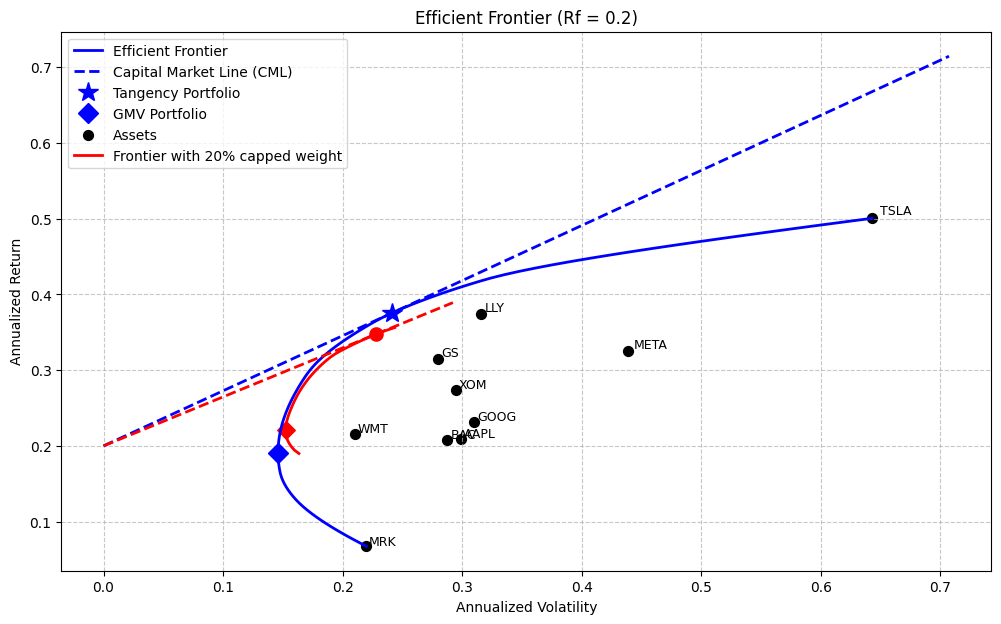

In [77]:
fig = plot_efficient_frontier(target_returns, target_vols, mu, Sigma,
                              ret_gmv, vol_gmv, ret_tan, vol_tan, sharpe_tan, rf=rf)

fig = add_frontier(fig, target_returns_cap, target_vols_cap,
    label_frontier="Frontier with 20% capped weight", color_frontier='red',
    vol_gmv=vol_gmv_cap, ret_gmv=ret_gmv_cap,
    vol_tan=vol_tan_cap, ret_tan=ret_tan_cap,
    sharpe_tan=sharpe_tan_cap, rf=rf,
)

plt.show()

## Backtesting

In [ ]:
def cumulative_portfolio_returns(weights, returns_df):
    """Compute cumulative returns of a portfolio"""
    port_ret = returns_df @ weights
    cum_ret = (1 + port_ret).cumprod()
    return cum_ret

# 1/n portfolio
w_eq = np.ones(len(tickers)) / len(tickers)

# Compute cumulative returns
cum_gmv = cumulative_portfolio_returns(w_gmv, returns_all)
cum_tan = cumulative_portfolio_returns(w_tan, returns_all)
cum_eq  = cumulative_portfolio_returns(w_eq, returns_all)
cum_gmv_cap = cumulative_portfolio_returns(w_gmv_cap, returns_all)
cum_tan_cap = cumulative_portfolio_returns(w_tan_cap, returns_all)

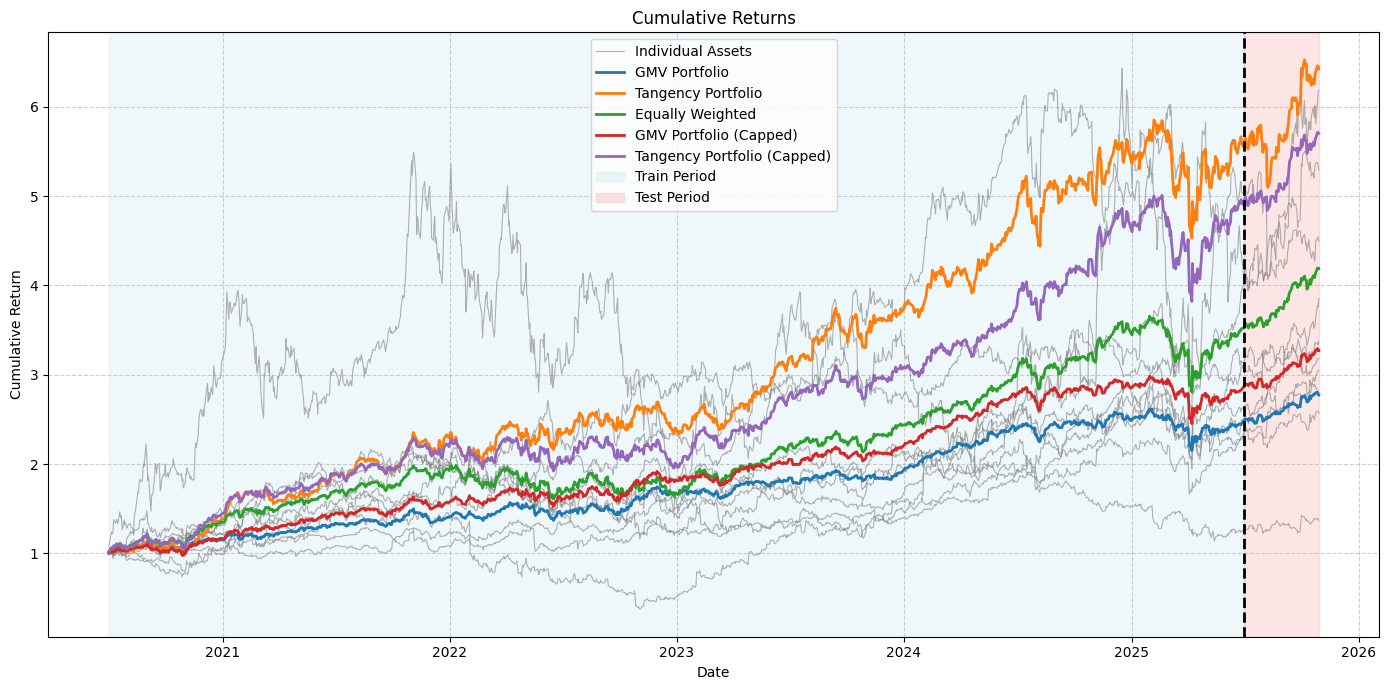

In [107]:
plt.figure(figsize=(14,7))

# Plot individual assets with thin lines
plt.plot([], color='gray', linewidth=0.8, alpha=0.6, label='Individual Assets')
for ticker in returns_all.columns:
    cum_asset = (1 + returns_all[ticker]).cumprod()
    plt.plot(cum_asset, color='gray', linewidth=0.8, alpha=0.6)

# Plot portfolios
plt.plot(cum_gmv, label='GMV Portfolio', linewidth=2)
plt.plot(cum_tan, label='Tangency Portfolio', linewidth=2)
plt.plot(cum_eq, label='Equally Weighted', linewidth=2)
plt.plot(cum_gmv_cap, label='GMV Portfolio (Capped)', linewidth=2)
plt.plot(cum_tan_cap, label='Tangency Portfolio (Capped)', linewidth=2)

# Shade train and test periods 
plt.axvspan(cum_gmv.index.min(), pd.to_datetime(test_start_date),
            color='lightblue', alpha=0.2, label='Train Period')
plt.axvspan(pd.to_datetime(test_start_date), cum_gmv.index.max(),
            color='lightcoral', alpha=0.2, label='Test Period')
# Marking start of test period
plt.axvline(pd.to_datetime(test_start_date), color='black', linestyle='--', linewidth=2)

plt.title('Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()